In [2]:
from influxdb import InfluxDBClient
import pandas as pd

Connection to DB, requires a host and user

In [3]:
client = InfluxDBClient ( host ='INSERT', port =8086 , username ='INSERT',
password = 'INSERT')
client.switch_database ('orkney')

In [4]:
def get_df(results):
    values = results.raw["series"][0]["values"]
    columns = results.raw["series"][0]["columns"]
    df = pd.DataFrame(values , columns = columns).set_index("time")
    df.index = pd.to_datetime(df.index) # Convert to datetime - index
    return df

In [5]:
generation = client.query(" SELECT mean(Total) FROM Generation where time > now()-365d GROUP BY time(3h)")
wind = client.query (" SELECT time, Speed, Direction, Source_time FROM MetForecasts where time > now()-365d and time <= now() and Lead_hours = '1'") # Query written in InfluxQL

In [6]:
gen_df = get_df(generation)
wind_df = get_df(wind)
print(gen_df)
print(wind_df)


                                mean
time                                
2021-10-07 12:00:00+00:00  17.892424
2021-10-07 15:00:00+00:00  18.719550
2021-10-07 18:00:00+00:00  16.318089
2021-10-07 21:00:00+00:00   7.719917
2021-10-08 00:00:00+00:00   6.795372
...                              ...
2022-10-07 00:00:00+00:00  29.809551
2022-10-07 03:00:00+00:00  35.401528
2022-10-07 06:00:00+00:00  35.739717
2022-10-07 09:00:00+00:00  24.858912
2022-10-07 12:00:00+00:00  34.986920

[2921 rows x 1 columns]
                              Speed Direction  Source_time
time                                                      
2021-10-07 15:00:00+00:00   8.04672         S   1633608000
2021-10-07 18:00:00+00:00   8.04672         S   1633618800
2021-10-07 21:00:00+00:00   5.81152         S   1633629600
2021-10-08 00:00:00+00:00   5.81152       SSW   1633640400
2021-10-08 03:00:00+00:00   4.02336       SSW   1633651200
...                             ...       ...          ...
2022-10-07 00:00:00+00

In [7]:
#Drop empyu values in mean total power output
gen_df.isnull().sum()
gen_df = gen_df.dropna()

In [8]:
#Joins the dataframes
resultdf = gen_df.join(wind_df, lsuffix='time')

In [9]:
skewness_speed = resultdf['Speed'].astype(float).skew()
print("Skewness of speed:", skewness_speed)
skewness_mean = resultdf['mean'].astype(float).skew()
print("Skewness of power:", skewness_mean)

Skewness of speed: 0.49007725604272434
Skewness of power: 0.07923363340872489


<function matplotlib.pyplot.show(close=None, block=None)>

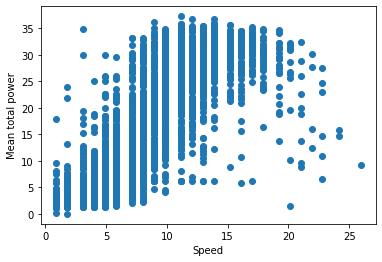

In [10]:
import matplotlib.pyplot as plt
speed = resultdf["Speed"]
mean = resultdf["mean"]
plt.scatter(speed, mean)
plt.xlabel("Speed")
plt.ylabel("Mean total power")
plt.show

Pipeline:

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

cat_preprocess = Pipeline([
     ("imputer_direction", SimpleImputer(strategy="most_frequent")),
     ("onehotencoder", OneHotEncoder(handle_unknown="ignore"))
])

columntransformer = ColumnTransformer([
    ("imputer_speed", SimpleImputer(strategy="mean"), ["Speed"]),
    ("categorization", cat_preprocess, ["Direction"])
], remainder="passthrough")


pipeline = Pipeline([
    ("columntransformer", columntransformer),
    ("scaler", RobustScaler(with_centering=False)),
    ("polynomial", PolynomialFeatures(3)),
    ("linearregression", LinearRegression())
])

In [12]:
#splitting data in training and test sets
from sklearn.model_selection import train_test_split

X = resultdf[["Speed", "Direction"]]
y = resultdf[["mean"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)


In [13]:
#fit model
from sklearn import set_config
set_config(display="diagram")

model = pipeline.fit(X_train, y_train)
model


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imputer_speed',
                                                  SimpleImputer(), ['Speed']),
                                                 ('categorization',
                                                  Pipeline(steps=[('imputer_direction',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Direction'])])),
                ('scaler', RobustScaler(with_centering=False)),
                ('polynomial', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

#Train and test data:

y_hat = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_hat)
mse = mean_squared_error(y_test, y_hat)
print("MAE:", mae)
print("MSE:", mse)

MAE: 4.453760106308198
MSE: 32.500668834265525


In [15]:
#Predictions on new data: mean power output based on wind speed and wind directions

forecasts = client.query(
    "SELECT time, Speed, Direction, Source_time FROM MetForecasts where time > now()"
)
for_df = get_df(forecasts)

newest_source_time = for_df["Source_time"].max()
newest_forecasts = for_df.loc[for_df["Source_time"] == newest_source_time].copy()
newest_forecasts_df = pd.DataFrame(data=newest_forecasts, columns=["Speed", "Direction"])
predictions = pipeline.predict(newest_forecasts_df)
print(predictions)

[[26.84170702]
 [24.89137327]
 [18.02117913]
 [21.82705136]
 [19.55461485]
 [14.71805028]
 [16.90094258]
 [19.32401067]
 [23.9657696 ]
 [23.9657696 ]
 [21.46785818]
 [22.86458903]
 [25.76814561]
 [29.68383855]
 [30.15886954]
 [34.4196182 ]
 [25.89408824]
 [28.2419116 ]
 [29.50991525]
 [30.12513878]
 [30.37692566]
 [30.87577388]
 [30.87577388]
 [27.53396483]
 [28.90184083]
 [29.79045497]
 [28.03193323]
 [26.62068599]
 [21.82705136]
 [14.46120018]
 [ 7.69779936]
 [ 9.91528907]
 [10.52973217]
 [16.29173263]
 [17.65497919]]
